In [1]:
!pip install imblearn
import warnings
warnings.filterwarnings('ignore')

You are using pip version 18.0, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
from pymongo import MongoClient
import pandas as pd

import numpy as np
from scipy import interp
import matplotlib.pyplot as plt
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.under_sampling import ClusterCentroids, NearMiss

/usr/lib/python3.4/importlib/_bootstrap.py:321: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.4/importlib/_bootstrap.py:321: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.4/importlib/_bootstrap.py:321: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.4/importlib/_bootstrap.py:321: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [3]:
conn = MongoClient('140.115.53.147', 27017)
conn.database_names()

/usr/local/lib/python3.4/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: database_names is deprecated. Use list_database_names instead.
  


['107_ELK',
 'AU_106_2_BIO',
 'AU_106_2_SE',
 'CYCU_1031SP',
 'CYCU_1041SP',
 'CYCU_1042OS',
 'CYCU_1051SP',
 'CYCU_1052OS',
 'KU_dataset_1',
 'KU_dataset_2',
 'NCU_1071MATH',
 'NCU_CHKA',
 'NCU_CHKB',
 'NCU_ETS',
 'NCUx107_Pre_college_calculas',
 'OULAD',
 'admin',
 'config',
 'local',
 'test']

In [16]:
db = conn['NCUx107_Pre_college_calculas']
collection = db['students_grades']
score_df = pd.DataFrame(list(collection.find()))
score_df = score_df.drop(['_id'], axis=1)
score_df = score_df[['studentId', 'finalScore']]
score_df = score_df.rename(index=str, columns={"studentId": "username"})
score_df.head(5)

,username,finalScore
0,107203516,82
1,107202510,82
2,107202506,64
3,107203518,72
4,107206504,77


In [19]:
db = conn['NCUx107_Pre_college_calculas']
collection = db['ma_w8.csv']
feature_df = pd.DataFrame(list(collection.find()))

feature_df = feature_df.drop(['_id'], axis=1)
feature_df = feature_df.drop(['email'], axis=1)
feature_df = feature_df.drop(['label'], axis=1)
feature_df = feature_df.drop(['course_id'], axis=1)

feature_df = feature_df.fillna('0')
feature_df.head(5)

,active_avg_count,active_num_days,active_sum_count,all_type_video_backward_seek_avg,all_type_video_backward_seek_sum,all_type_video_forward_seek_avg,all_type_video_forward_seek_sum,all_type_video_seek_avg,all_type_video_seek_sum,complete_rate,...,video_play_avg,video_play_sum,video_stop_avg,video_stop_backward_seek_avg,video_stop_backward_seek_sum,video_stop_sum,video_sum_count,watched_time_hour,watched_time_weekday,week
0,20.000000,1,20,0.000000,0,0.000000,0,0.000000,0,0.000000,...,0.000000,0,0.000000,0.000000,0,0,1,0.000000,0,3
1,2.000000,1,2,0.000000,0,0.000000,0,0.000000,0,0.000000,...,0.000000,0,0.000000,0.000000,0,0,0,0.000000,0,5
2,14.000000,1,14,0.000000,0,0.000000,0,0.000000,0,0.000000,...,0.000000,0,0.000000,0.000000,0,0,0,0.000000,0,-1
3,272.000000,3,816,2.250000,27,3.250000,39,5.500000,66,0.916667,...,6.500000,78,0.416667,0.083333,1,5,85,8.101351,7,0
4,104.666667,3,314,1.428571,10,1.428571,10,2.857143,20,0.571429,...,3.857143,27,0.000000,0.000000,0,0,29,11.969146,1,1


In [20]:
list(feature_df)

['active_avg_count',
 'active_num_days',
 'active_sum_count',
 'all_type_video_backward_seek_avg',
 'all_type_video_backward_seek_sum',
 'all_type_video_forward_seek_avg',
 'all_type_video_forward_seek_sum',
 'all_type_video_seek_avg',
 'all_type_video_seek_sum',
 'complete_rate',
 'forum_avg_count',
 'forum_num_days',
 'forum_sum_count',
 'incomplete_rate',
 'num_complete',
 'num_days',
 'num_incomplete',
 'num_watched',
 'pause_video_avg',
 'pause_video_sum',
 'problem_avg_count',
 'problem_num_days',
 'problem_sum_count',
 'seek_video_avg',
 'seek_video_sum',
 'stop_video_avg',
 'stop_video_sum',
 'username',
 'video_avg_count',
 'video_backward_seek_avg',
 'video_backward_seek_sum',
 'video_events_avg',
 'video_events_sum',
 'video_forward_seek_avg',
 'video_forward_seek_sum',
 'video_num_days',
 'video_pause_avg',
 'video_pause_backward_seek_avg',
 'video_pause_backward_seek_sum',
 'video_pause_forward_seek_avg',
 'video_pause_forward_seek_sum',
 'video_pause_sum',
 'video_play_av

In [21]:
ncu_ets = pd.merge(feature_df, score_df, on='username')
ncu_ets = ncu_ets.drop(['username'], axis=1)
ncu_ets = ncu_ets.drop(['week'], axis=1)
ncu_ets = ncu_ets.astype(float)
ncu_ets['class'] = ncu_ets['finalScore'] < 60
ncu_ets = ncu_ets.drop(['finalScore'], axis=1)
ncu_ets.head(5)

,active_avg_count,active_num_days,active_sum_count,all_type_video_backward_seek_avg,all_type_video_backward_seek_sum,all_type_video_forward_seek_avg,all_type_video_forward_seek_sum,all_type_video_seek_avg,all_type_video_seek_sum,complete_rate,...,video_play_avg,video_play_sum,video_stop_avg,video_stop_backward_seek_avg,video_stop_backward_seek_sum,video_stop_sum,video_sum_count,watched_time_hour,watched_time_weekday,class
0,96.000000,1.0,96.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,...,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,True
1,36.000000,1.0,36.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,...,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,True
2,122.333333,6.0,734.0,1.500000,6.0,6.000000,24.0,7.500000,30.0,0.500000,...,8.500000,34.0,0.000000,0.0,0.0,0.0,36.0,15.174407,2.0,False
3,243.857143,7.0,1707.0,1.076923,14.0,4.153846,54.0,5.230769,68.0,0.538462,...,6.230769,81.0,0.076923,0.0,0.0,1.0,99.0,2.122340,7.0,False
4,139.000000,7.0,973.0,2.300000,23.0,2.900000,29.0,5.200000,52.0,0.400000,...,6.200000,62.0,0.300000,0.2,2.0,3.0,52.0,1.845016,7.0,False


In [25]:
X = ncu_ets.drop(['class'], axis=1)
X = X.values
y = ncu_ets['class']

# Run classifier with cross-validation and plot ROC curves
cv = StratifiedKFold(n_splits=5)

clf_binary = svm.SVC(kernel='rbf', 
                     probability=True,
                     cache_size=700,
                     random_state=5,
                     gamma='scale')

clf_one = svm.OneClassSVM(kernel="rbf",
                         cache_size=700,
                         random_state=5,
                         gamma='scale')


In [26]:
def compute_roc (X, y, title):
    
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    
    i = 0
    for train, test in cv.split(X, y):

        probas_ = clf_binary.fit(X[train], y[train]).predict_proba(X[test])
        # Compute ROC curve and area the curve
        fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])
        tprs.append(interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        plt.plot(fpr, tpr, lw=1, alpha=0.3,
                 label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

        i += 1
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
             label='Chance', alpha=.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    plt.plot(mean_fpr, mean_tpr, color='b',
             label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
             lw=2, alpha=.8)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                     label=r'$\pm$ 1 std. dev.')

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic of '+ title)
    plt.legend(loc="lower right")
    
    return plt

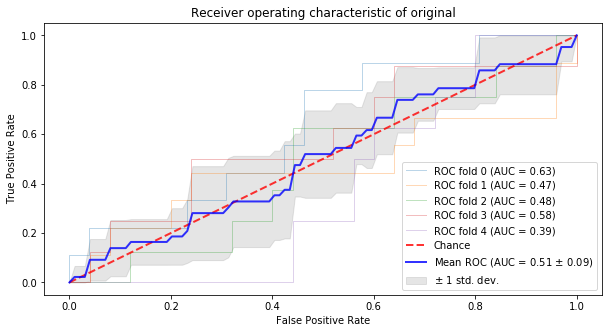

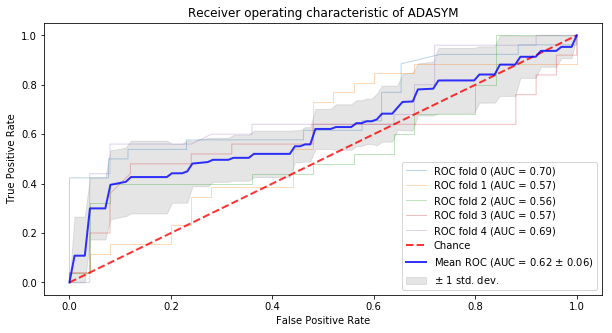

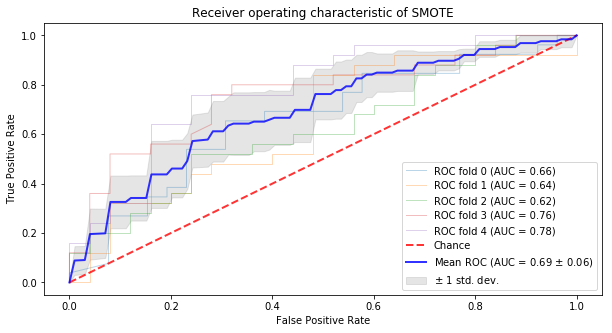

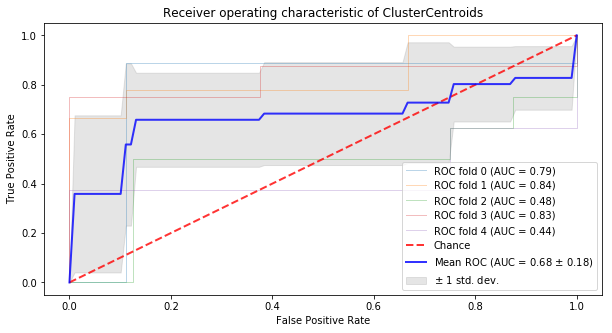

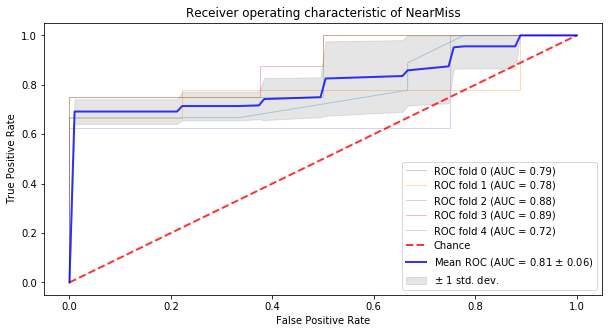

In [27]:
plt.figure(figsize=(10, 5))
plt = compute_roc(X, y, title='original')
plt.show()

plt.figure(figsize=(10, 5))
sm = ADASYN(ratio = 1.0)
res_X, res_y = sm.fit_sample(X, y)
plt = compute_roc(res_X, res_y, title='ADASYM')
plt.show()

plt.figure(figsize=(10, 5))
sm = SMOTE(ratio = 1.0)
res_X, res_y = sm.fit_sample(X, y)
plt = compute_roc(res_X, res_y, title='SMOTE')
plt.show()

plt.figure(figsize=(10, 5))
cc = ClusterCentroids(random_state=0)
res_X, res_y = cc.fit_sample(X, y)
plt = compute_roc(res_X, res_y, title='ClusterCentroids')
plt.show()

plt.figure(figsize=(10, 5))
nm = NearMiss(random_state=0)
res_X, res_y = nm.fit_sample(X, y)
plt = compute_roc(res_X, res_y, title='NearMiss')
plt.show()

In [10]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
import matplotlib.pyplot as plt
from sklearn.utils.fixes import signature

#X_train, X_test, y_train, y_test = train_test_split(kyoto_x, kyoto_y, test_size=0.3)

precision, recall, _ = precision_recall_curve(y[test], probas_[:, 1])
average_precision = average_precision_score(y[test], probas_[:, 1])

# In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})

plt.figure(figsize=(10, 5))
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
          average_precision))

NameError: name 'test' is not defined

In [ ]:
sm = ADASYN(ratio = 1.0)
x_train_res, y_train_res = sm.fit_sample(X[train], y[train])

In [ ]:
y[train].to_frame()['class'].value_counts()

In [ ]:
pd.DataFrame(y_train_res)[0].value_counts()